In [10]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_encoded.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   itad_id                   30947 non-null  object 
 1   appid                     30947 non-null  float64
 2   title                     30947 non-null  object 
 3   release_date              30947 non-null  object 
 4   early_access              30947 non-null  int64  
 5   mature                    30947 non-null  int64  
 6   launch_price              30947 non-null  float64
 7   days_to_first_sale        30947 non-null  int64  
 8   Windows                   30947 non-null  int64  
 9   Mac                       30947 non-null  int64  
 10  Linux                     30947 non-null  int64  
 11  Achievements              30947 non-null  int64  
 12  Developers                30947 non-null  object 
 13  Publishers                30947 non-null  object 
 14  Catego

<Axes: xlabel='days_to_first_sale', ylabel='Count'>

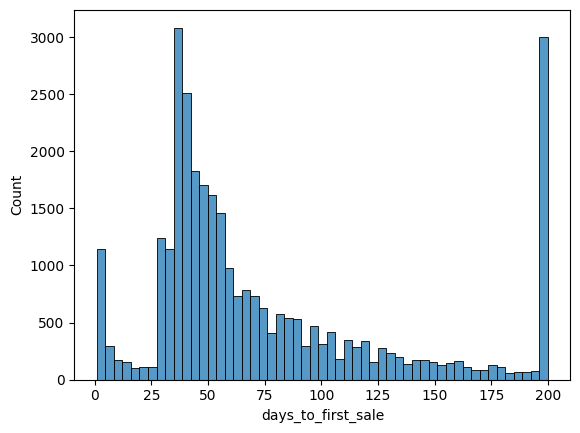

In [18]:
sns.histplot(data=df, x='days_to_first_sale')

In [5]:
# 0) make sure release_date is datetime
df = df.copy()
df["release_date"] = pd.to_datetime(df["release_date"])

# 1) Steam sale calendar (year -> list of (name, start, end))
#    Edit/extend here if needed.
SALE_WINDOWS = {
    2021: [
        ("lunar_new_year", "2021-02-11", "2021-02-15"),
        ("summer",        "2021-06-24", "2021-07-08"),
        ("autumn",        "2021-11-24", "2021-11-30"),
        ("winter",        "2021-12-22", "2022-01-05"),
    ],
    2022: [
        ("lunar_new_year", "2022-01-27", "2022-02-03"),
        ("summer",         "2022-06-23", "2022-07-07"),
        ("autumn",         "2022-11-22", "2022-11-29"),
        ("winter",         "2022-12-22", "2023-01-05"),
    ],
    2023: [
        ("spring", "2023-03-16", "2023-03-23"),  # Spring sale introduced in 2023
        ("summer", "2023-06-29", "2023-07-13"),
        ("autumn", "2023-11-21", "2023-11-28"),
        ("winter", "2023-12-21", "2024-01-04"),
    ],
    2024: [
        ("spring", "2024-03-14", "2024-03-21"),
        ("summer", "2024-06-27", "2024-07-11"),
        ("autumn", "2024-11-26", "2024-12-03"),  # planned/typical window
        ("winter", "2024-12-19", "2025-01-02"),
    ],
}

# 2) Build a tidy calendar dataframe from SALE_WINDOWS
rows = []
for yr, windows in SALE_WINDOWS.items():
    for name, start, end in windows:
        rows.append({
            "year": yr,
            "sale_name": name,
            "start": pd.to_datetime(start),
            "end":   pd.to_datetime(end),
        })
sale_df = pd.DataFrame(rows)

# 3) Helper: for each game, compute whether release falls in any sale window
def in_window(date, start, end):
    return (date >= start) & (date <= end)

# Initialize per-sale flags
df["is_spring_sale_window"]        = 0
df["is_lunar_new_year_window"]     = 0
df["is_summer_sale_window_cal"]    = 0  # keep separate from your existing flag if you want
df["is_autumn_sale_window"]        = 0
df["is_winter_sale_window"]        = 0

# Mark flags by iterating over windows (vectorized per window)
for _, row in sale_df.iterrows():
    mask = in_window(df["release_date"], row["start"], row["end"])
    if row["sale_name"] == "spring":
        df.loc[mask, "is_spring_sale_window"] = 1
    elif row["sale_name"] == "lunar_new_year":
        df.loc[mask, "is_lunar_new_year_window"] = 1
    elif row["sale_name"] == "summer":
        df.loc[mask, "is_summer_sale_window_cal"] = 1
    elif row["sale_name"] == "autumn":
        df.loc[mask, "is_autumn_sale_window"] = 1
    elif row["sale_name"] == "winter":
        df.loc[mask, "is_winter_sale_window"] = 1

# Any sale window
df["is_any_steam_sale_window"] = (
    df["is_spring_sale_window"]
    | df["is_lunar_new_year_window"]
    | df["is_summer_sale_window_cal"]
    | df["is_autumn_sale_window"]
    | df["is_winter_sale_window"]
).astype(int)

# 4) Distance to nearest sale windows
# Build arrays of all sale starts and ends (covering all years)
all_starts = sale_df["start"].sort_values().to_numpy()
all_ends   = sale_df["end"].sort_values().to_numpy()

# For each date, compute days to next start (>= date) and days since previous end (<= date)
dates = df["release_date"].to_numpy()

# vectorized next-start distance
next_idx = np.searchsorted(all_starts, dates, side="left")
# if there is a next sale start
next_dist = np.full(len(dates), np.nan)
valid_next = next_idx < len(all_starts)
next_dist[valid_next] = (all_starts[next_idx[valid_next]] - dates[valid_next]).astype("timedelta64[D]").astype(int)
# if already inside a sale, distance is 0
next_dist[df["is_any_steam_sale_window"].values == 1] = 0
df["days_to_next_steam_sale"] = next_dist

# vectorized prev-end distance
prev_idx = np.searchsorted(all_ends, dates, side="right") - 1
prev_dist = np.full(len(dates), np.nan)
valid_prev = prev_idx >= 0
prev_dist[valid_prev] = (dates[valid_prev] - all_ends[prev_idx[valid_prev]]).astype("timedelta64[D]").astype(int)
# if inside a sale, since-prev is 0
prev_dist[df["is_any_steam_sale_window"].values == 1] = 0
df["days_since_prev_steam_sale"] = prev_dist

# 5) (Optional) a compact “near sale” flag (e.g., within 7 days of a sale start)
df["within_7d_of_steam_sale"] = ((df["days_to_next_steam_sale"] >= 0) & (df["days_to_next_steam_sale"] <= 7)).astype(int)

# Peek at the new columns
df[[
    "release_date",
    "is_spring_sale_window", "is_lunar_new_year_window", "is_summer_sale_window_cal",
    "is_autumn_sale_window", "is_winter_sale_window", "is_any_steam_sale_window",
    "days_to_next_steam_sale", "days_since_prev_steam_sale", "within_7d_of_steam_sale"
]].head()

,release_date,is_spring_sale_window,is_lunar_new_year_window,is_summer_sale_window_cal,is_autumn_sale_window,is_winter_sale_window,is_any_steam_sale_window,days_to_next_steam_sale,days_since_prev_steam_sale,within_7d_of_steam_sale
0,2023-10-28,0,0,0,0,0,0,24.0,107.0,0
1,2021-10-05,0,0,0,0,0,0,50.0,89.0,0
2,2023-10-06,0,0,0,0,0,0,46.0,85.0,0
3,2022-10-17,0,0,0,0,0,0,36.0,102.0,0
4,2022-10-14,0,0,0,0,0,0,39.0,99.0,0


In [7]:
df['is_autumn_sale_window'].value_counts()

is_autumn_sale_window
0    30557
1      390
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   itad_id                     30947 non-null  object        
 1   appid                       30947 non-null  float64       
 2   title                       30947 non-null  object        
 3   release_date                30947 non-null  datetime64[ns]
 4   early_access                30947 non-null  int64         
 5   mature                      30947 non-null  int64         
 6   launch_price                30947 non-null  float64       
 7   days_to_first_sale          30947 non-null  int64         
 8   Windows                     30947 non-null  int64         
 9   Mac                         30947 non-null  int64         
 10  Linux                       30947 non-null  int64         
 11  Achievements                30947 non-null  int64     

In [9]:
df.drop(columns=['is_summer_sale_window'], inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   itad_id                     30947 non-null  object        
 1   appid                       30947 non-null  float64       
 2   title                       30947 non-null  object        
 3   release_date                30947 non-null  datetime64[ns]
 4   early_access                30947 non-null  int64         
 5   mature                      30947 non-null  int64         
 6   launch_price                30947 non-null  float64       
 7   days_to_first_sale          30947 non-null  int64         
 8   Windows                     30947 non-null  int64         
 9   Mac                         30947 non-null  int64         
 10  Linux                       30947 non-null  int64         
 11  Achievements                30947 non-null  int64     

In [11]:
# normalize titles so numbered/edition variants cluster together
_EDITION_WORDS = {
    "goty","game of the year","deluxe","ultimate","gold","definitive","complete",
    "remaster","remastered","enhanced","hd","vr","demo","beta","alpha","prologue",
    "epilogue","soundtrack","bundle","pack","dlc","season pass"
}
_ROMAN = {" ii":" 2"," iii":" 3"," iv":" 4"," v":" 5"," vi":" 6"," vii":" 7"," viii":" 8"," ix":" 9"," x":" 10"}

def normalize_title(s: str) -> str:
    s = s.lower()
    s = s.replace("&", " and ")
    s = re.sub(r"[:\-_/|]", " ", s)
    s = re.sub(r"[^\w\s]", "", s)        # remove punctuation
    s = re.sub(r"\s+", " ", s).strip()

    # map roman numerals (when standalone tokens) to digits
    for k,v in _ROMAN.items():
        s = re.sub(rf"{re.escape(k)}(\b)", v, s)

    # drop edition words
    tokens = [t for t in s.split() if t not in _EDITION_WORDS]
    s = " ".join(tokens)

    # optionally drop lone years (avoid fragmenting by 2018/2020 etc.)
    s = re.sub(r"\b(19|20)\d{2}\b", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# df must have: title, release_date (datetime), days_to_first_sale (int)
df_work = df.copy()
df_work["release_date"] = pd.to_datetime(df_work["release_date"])
df_work["title_norm"] = df_work["title"].astype(str).apply(normalize_title)

# TF-IDF on character n-grams is very robust to small naming differences
tfv = TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=2)  # min_df filters one-offs a bit
X = tfv.fit_transform(df_work["title_norm"])  # sparse [n_titles x vocab]

# kNN in cosine space
k = 20                         # neighbors per title
nn = NearestNeighbors(n_neighbors=k, metric="cosine", n_jobs=-1)
nn.fit(X)
distances, indices = nn.kneighbors(X, return_distance=True)

# build sparse adjacency for pairs with similarity >= thresh
SIM_THRESH = 0.45              # cosine similarity threshold (tune 0.35–0.6)
rows, cols, data = [], [], []
for i, (drow, irow) in enumerate(zip(distances, indices)):
    sims = 1.0 - drow
    mask = sims >= SIM_THRESH
    js = irow[mask]
    ss = sims[mask]
    for j, s in zip(js, ss):
        if i == j: 
            continue
        rows.append(i); cols.append(j); data.append(1.0)  # unweighted graph edge

n = X.shape[0]
A = csr_matrix((data, (rows, cols)), shape=(n, n))
# make it symmetric
A = A.maximum(A.T)

# connected components = franchise clusters
n_comp, labels = connected_components(csgraph=A, directed=False, return_labels=True)
df_work["franchise_id"] = labels

In [13]:
def pick_label(sub):
    # choose shortest normalized title as canonical label
    j = sub["title_norm"].str.len().idxmin()
    return sub.loc[j, "title_norm"]

label_map = (df_work.groupby("franchise_id")
                    .apply(pick_label)
                    .rename("franchise_label"))
df_work = df_work.join(label_map, on="franchise_id")

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_44769/1438155456.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_label)


In [15]:
# 0) make sure it's sorted by franchise & release date
df_work = df_work.sort_values(["franchise_id", "release_date"]).reset_index(drop=True)

# 1) how many prior entries in the same franchise (0 for the first)
df_work["franchise_count_prev"] = df_work.groupby("franchise_id").cumcount()

# 2) average of prior entries only (leakage-safe)
grp = df_work.groupby("franchise_id")["days_to_first_sale"]

# cumulative sum up to current row (inclusive)
cum_sum_incl = grp.cumsum()

# sum of prior rows = cum_sum_incl - current value
prior_sum = cum_sum_incl - df_work["days_to_first_sale"]

prior_cnt = df_work["franchise_count_prev"]  # number of prior rows

avg_prev = np.where(prior_cnt > 0, prior_sum / prior_cnt, np.nan)
global_mean = df_work["days_to_first_sale"].mean()

df_work["franchise_avg_days_prev"] = np.where(
    np.isnan(avg_prev), global_mean, avg_prev
)

In [16]:
print("Franchises discovered:", df_work["franchise_id"].nunique())
print(df_work[["title","title_norm","franchise_label","franchise_id","franchise_count_prev","franchise_avg_days_prev"]].head(10))

Franchises discovered: 12391
                                 title                         title_norm  \
0  Silent Night - A Christmas Delivery  silent night a christmas delivery   
1                    Bad boy simulator                  bad boy simulator   
2                         Zombie Alert                       zombie alert   
3                   Tower Defense Hero                 tower defense hero   
4                     Infinite Gateway                   infinite gateway   
5                         Saving Grace                       saving grace   
6                Hexahedral Pathfinder              hexahedral pathfinder   
7                        Fly The Cloud                      fly the cloud   
8                     Fallen Rebellion                   fallen rebellion   
9                Traceur's Dreamlab VR                  traceurs dreamlab   

  franchise_label  franchise_id  franchise_count_prev  franchise_avg_days_prev  
0             oro             0           

In [17]:
df_work[["title","title_norm","franchise_label","franchise_id","franchise_count_prev","franchise_avg_days_prev"]]

,title,title_norm,franchise_label,franchise_id,franchise_count_prev,franchise_avg_days_prev
0,Silent Night - A Christmas Delivery,silent night a christmas delivery,oro,0,0,75.944292
1,Bad boy simulator,bad boy simulator,oro,0,1,200.000000
2,Zombie Alert,zombie alert,oro,0,2,125.500000
3,Tower Defense Hero,tower defense hero,oro,0,3,150.333333
4,Infinite Gateway,infinite gateway,oro,0,4,129.000000
...,...,...,...,...,...,...
30942,TIEBREAK+: Official Game of the ATP and WTA,tiebreak official game of the atp and wta,tiebreak official game of the atp and wta,12386,0,75.944292
30943,Song Song: Bóng Ma Thủ Đô,song song bóng ma thủ đô,song song bóng ma thủ đô,12387,0,75.944292
30944,Escape the Ayurok DEMAKE,escape the ayurok demake,escape the ayurok demake,12388,0,75.944292
30945,Lambda Spellcrafting Academy - Learn to Program!,lambda spellcrafting academy learn to program,lambda spellcrafting academy learn to program,12389,0,75.944292


In [23]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   itad_id                     30947 non-null  object        
 1   appid                       30947 non-null  float64       
 2   title                       30947 non-null  object        
 3   release_date                30947 non-null  datetime64[ns]
 4   early_access                30947 non-null  int64         
 5   mature                      30947 non-null  int64         
 6   launch_price                30947 non-null  float64       
 7   days_to_first_sale          30947 non-null  int64         
 8   Windows                     30947 non-null  int64         
 9   Mac                         30947 non-null  int64         
 10  Linux                       30947 non-null  int64         
 11  Achievements                30947 non-null  int64     

In [24]:
kaggle_df = pd.read_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/Kaggle datasets/93182_steam_games.csv')
kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93182 entries, 0 to 93181
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       93182 non-null  int64  
 1   Name                        93179 non-null  object 
 2   Release date                93182 non-null  object 
 3   Estimated owners            16462 non-null  object 
 4   Peak CCU                    93182 non-null  int64  
 5   Required age                93182 non-null  int64  
 6   Price                       93182 non-null  float64
 7   DLC count                   93182 non-null  int64  
 8   About the game              88392 non-null  object 
 9   Supported languages         93182 non-null  object 
 10  Full audio languages        93182 non-null  object 
 11  Reviews                     10599 non-null  object 
 12  Header image                93182 non-null  object 
 13  Website                     416

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_44769/377124396.py:1: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  kaggle_df = pd.read_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/Kaggle datasets/93182_steam_games.csv')


In [29]:
# renaming "AppID" to "appid" to match with df_work

kaggle_df.rename(columns={"AppID": "appid"}, inplace=True)

In [30]:
# merging the "Supported languages" column from kaggle_df into df_work

df_final = df_work.merge(kaggle_df[['appid', 'Supported languages']], on='appid', how='left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   itad_id                     30947 non-null  object        
 1   appid                       30947 non-null  float64       
 2   title                       30947 non-null  object        
 3   release_date                30947 non-null  datetime64[ns]
 4   early_access                30947 non-null  int64         
 5   mature                      30947 non-null  int64         
 6   launch_price                30947 non-null  float64       
 7   days_to_first_sale          30947 non-null  int64         
 8   Windows                     30947 non-null  int64         
 9   Mac                         30947 non-null  int64         
 10  Linux                       30947 non-null  int64         
 11  Achievements                30947 non-null  int64     

In [33]:
df_final[['Supported languages']]

,Supported languages
0,['English']
1,['English']
2,['English']
3,"['English', 'Simplified Chinese']"
4,['English']
...,...
30942,"['English', 'French', 'Italian', 'German', 'Sp..."
30943,['English']
30944,['English']
30945,['English']


In [34]:
# converting "Supported languages" column to count of languages

def count_languages(lang_str):
    if pd.isna(lang_str):
        return 0
    # Split by comma and strip whitespace
    languages = [lang.strip() for lang in lang_str.split(',')]
    return len(languages)

df_final['num_supported_languages'] = df_final['Supported languages'].apply(count_languages)
df_final[['Supported languages', 'num_supported_languages']]

,Supported languages,num_supported_languages
0,['English'],1
1,['English'],1
2,['English'],1
3,"['English', 'Simplified Chinese']",2
4,['English'],1
...,...,...
30942,"['English', 'French', 'Italian', 'German', 'Sp...",12
30943,['English'],1
30944,['English'],1
30945,['English'],1


In [35]:
cluster_df = pd.read_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_genre_clusters.csv')
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   itad_id                                30947 non-null  object 
 1   appid                                  30947 non-null  float64
 2   title                                  30947 non-null  object 
 3   release_date                           30947 non-null  object 
 4   early_access                           30947 non-null  int64  
 5   mature                                 30947 non-null  int64  
 6   launch_price                           30947 non-null  float64
 7   days_to_first_sale                     30947 non-null  int64  
 8   Windows                                30947 non-null  int64  
 9   Mac                                    30947 non-null  int64  
 10  Linux                                  30947 non-null  int64  
 11  Ac

In [36]:
df_final = df_final.merge(cluster_df[['appid', 'genre_cluster_sports_competitive', 'genre_cluster_strategy_sim', 'genre_cluster_story_action_mainstream', 
                                      'genre_cluster_mmo']], on='appid', how='left')

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 60 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   itad_id                                30947 non-null  object        
 1   appid                                  30947 non-null  float64       
 2   title                                  30947 non-null  object        
 3   release_date                           30947 non-null  datetime64[ns]
 4   early_access                           30947 non-null  int64         
 5   mature                                 30947 non-null  int64         
 6   launch_price                           30947 non-null  float64       
 7   days_to_first_sale                     30947 non-null  int64         
 8   Windows                                30947 non-null  int64         
 9   Mac                                    30947 non-null  int64 

In [37]:
review_df = pd.read_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_enriched.csv')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  bool   
 10  Mac                 30947 non-null  bool   
 11  Linux               30947 non-null  bool   
 12  Achievements        30947 non-null  float64
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genr

In [38]:
# adding "review_score" and "review_count" columns from review_df into df_final

df_final = df_final.merge(review_df[['appid', 'review_score', 'review_count']], on='appid', how='left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   itad_id                                30947 non-null  object        
 1   appid                                  30947 non-null  float64       
 2   title                                  30947 non-null  object        
 3   release_date                           30947 non-null  datetime64[ns]
 4   early_access                           30947 non-null  int64         
 5   mature                                 30947 non-null  int64         
 6   launch_price                           30947 non-null  float64       
 7   days_to_first_sale                     30947 non-null  int64         
 8   Windows                                30947 non-null  int64         
 9   Mac                                    30947 non-null  int64 

In [41]:
# imputing the missing values in "review_score" and "review_count" columns with the mean and median respectively.
# adding a flag column "has_reviews" to indicate whether a game has reviews or not.

df_final['review_score'].fillna(df_final['review_score'].mean(), inplace=True)
df_final['review_count'].fillna(df_final['review_count'].median(), inplace=True)
df_final['has_reviews'] = np.where(df_final['review_count'] > 0, 1, 0)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 63 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   itad_id                                30947 non-null  object        
 1   appid                                  30947 non-null  float64       
 2   title                                  30947 non-null  object        
 3   release_date                           30947 non-null  datetime64[ns]
 4   early_access                           30947 non-null  int64         
 5   mature                                 30947 non-null  int64         
 6   launch_price                           30947 non-null  float64       
 7   days_to_first_sale                     30947 non-null  int64         
 8   Windows                                30947 non-null  int64         
 9   Mac                                    30947 non-null  int64 

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_44769/139974999.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['review_score'].fillna(df_final['review_score'].mean(), inplace=True)
/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_44769/139974999.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whic

In [42]:
df_final.drop(columns=['gen_indie', 'gen_rpg', 'gen_casual', 'gen_simulation', 'gen_strategy', 'gen_action', 'gen_adventure',
                       'gen_sports', 'gen_racing', 'gen_massivelymultiplayer', 'Supported languages', 'Windows', 'Mac', 'Linux', 'title_norm',
                       'franchise_id', 'franchise_label', 'time_since_steam_launch', ], inplace=True)

In [43]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   itad_id                                30947 non-null  object        
 1   appid                                  30947 non-null  float64       
 2   title                                  30947 non-null  object        
 3   release_date                           30947 non-null  datetime64[ns]
 4   early_access                           30947 non-null  int64         
 5   mature                                 30947 non-null  int64         
 6   launch_price                           30947 non-null  float64       
 7   days_to_first_sale                     30947 non-null  int64         
 8   Achievements                           30947 non-null  int64         
 9   Developers                             30947 non-null  object

In [44]:
# saving the final dataframe to a csv file

df_final.to_csv('/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_updated.csv', index=False)